In [0]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
import torch
import helper
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch import nn
from torch import optim
from torchsummary import summary
from torchvision import datasets, transforms

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/modulation-dataset

/content/gdrive/My Drive/modulation-dataset


# GPU or CPU

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [0]:
# load dataset
data_dict = cPickle.load(open("RML2016.10b.dat",'rb'), encoding='bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data_dict.keys())))), [1,0])
data = []  
labels = []
for mod in mods:
    for snr in snrs:
        data.append(data_dict[(mod, snr)])
        for i in range(data_dict[(mod, snr)].shape[0]):  labels.append((mod, snr))
data = np.vstack(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(1200000, 2, 128)
(1200000, 2)


# Splitting Data

In [0]:
x_train_validate, x_test, y_train_validate, y_test = train_test_split(data, labels, test_size=0.5, shuffle = True)

print(x_train_validate.shape)
print(x_test.shape)
print(y_train_validate.shape)
print(y_test.shape)

#Validation 5% from training set

x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size= 0.05, shuffle=False)

print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)




(600000, 2, 128)
(600000, 2, 128)
(600000, 2)
(600000, 2)
(570000, 2, 128)
(30000, 2, 128)
(570000, 2)
(30000, 2)


# Mapping Labels

In [0]:
one_hot_encoder = preprocessing.OneHotEncoder()

one_hot_encoder.fit(y_train[:, 0].reshape(-1,1))
print(y_train[0])
y_train_snr = y_train[:, 1]
y_train_snr = y_train_snr.astype(int)
y_train = one_hot_encoder.transform(y_train[:, 0].reshape(-1,1)).todense()
print(one_hot_encoder.inverse_transform(y_train[0]))

one_hot_encoder.fit(y_validate[:, 0].reshape(-1,1))
print(y_validate[0])
y_validate_snr = y_validate[:, 1]
y_validate_snr = y_validate_snr.astype(int)
y_validate = one_hot_encoder.transform(y_validate[:, 0].reshape(-1,1)).todense()
print(one_hot_encoder.inverse_transform(y_validate[0]))

one_hot_encoder.fit(y_test[:, 0].reshape(-1,1))
print(y_test[0])
y_test_snr = y_test[:, 1]
y_test_snr = y_test_snr.astype(int)
y_test = one_hot_encoder.transform(y_test[:, 0].reshape(-1,1)).todense()
print(one_hot_encoder.inverse_transform(y_test[0]))
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

print(y_train[0])
print(y_train_snr[0])
print(y_test[0])
print(y_test_snr[0])
print(y_validate[0])
print(y_validate_snr[0])


[b'GFSK' b'18']
[[b'GFSK']]
[b'8PSK' b'-20']
[[b'8PSK']]
[b'CPFSK' b'-18']
[[b'CPFSK']]
(570000, 10)
(600000, 10)
(30000, 10)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
18
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
-18
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
-20


# Changing From Numpy to Tensors

In [0]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_validate = torch.from_numpy(x_validate)
y_validate  = torch.from_numpy(y_validate)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

# Defining Fully Connected Neural Network

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden1 = nn.Linear(256, 512)
        self.hidden2 = nn.Linear(512, 1024)
        self.output = nn.Linear(1024, 10)
        
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output(x)
        
        
        
        
        return x

# Building FC Model

In [0]:
model = Network()
model.load_state_dict(torch.load('MODEL_FC_RAW.pt'))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
print(model)

model.to(device)

Network(
  (hidden1): Linear(in_features=256, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


Network(
  (hidden1): Linear(in_features=256, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

# Training FC Model 

In [0]:
n_epochs = 100
steps = 0

batch_size = 1024
num_workers = 0

validate_loss_min = 1.259460 # track change in validation loss

y_train = y_train.long()
y_validate = y_validate.long()
y_test = y_test.long()

# divide data into batches 
x_train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, num_workers=num_workers)
y_train_loader = torch.utils.data.DataLoader(y_train, batch_size=batch_size, num_workers=num_workers)

x_validate_loader = torch.utils.data.DataLoader(x_validate, batch_size=batch_size, num_workers=num_workers)
y_validate_loader = torch.utils.data.DataLoader(y_validate, batch_size=batch_size, num_workers=num_workers)

x_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size, num_workers=num_workers)
y_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size, num_workers=num_workers)

train_losses, validate_losses = [], []
for e in range(n_epochs):
    running_loss = 0
    for samples, labels in zip(x_train_loader, y_train_loader):
      
        # Move input and label tensors to the default device
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        probabilities = model(torch.unsqueeze(samples, 1))  # add a depth size 1
        loss = criterion(probabilities, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        validate_loss = 0
        accuracy = 0
        correct = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for samples, labels in zip(x_validate_loader, y_validate_loader):
              
                # Move input and label tensors to the default device
                samples, labels = samples.to(device), labels.to(device)
                
                
                probabilities = model(torch.unsqueeze(samples, 1))  # add a depth size 1
                validate_loss += criterion(probabilities, torch.max(labels, 1)[1])    
                
                top_p, top_class = probabilities.topk(1, dim=1)
                equals = top_class == torch.max(labels, 1)[1].view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                correct += torch.sum(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(y_train_loader))
        validate_losses.append(validate_loss/len(y_validate_loader))
        scheduler.step(validate_losses[-1])
        
        # save the model with the minimum validation loss
        if validate_losses[-1] <= validate_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            validate_loss_min, validate_losses[-1]))
            torch.save(model.state_dict(), 'MODEL_FC_RAW.pt')
            validate_loss_min = validate_losses[-1]
        

        print("Epoch: {}/{}.. ".format(e+1, n_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(validate_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(y_validate_loader)))
        #print("correct = ".correct)

Validation loss decreased (1.259460 --> 1.200954).  Saving model ...
Epoch: 1/100..  Training Loss: 1.228..  Validation Loss: 1.201..  Validation Accuracy: 0.502
Validation loss decreased (1.200954 --> 1.197962).  Saving model ...
Epoch: 2/100..  Training Loss: 1.219..  Validation Loss: 1.198..  Validation Accuracy: 0.502
Epoch: 3/100..  Training Loss: 1.211..  Validation Loss: 1.198..  Validation Accuracy: 0.500
Epoch: 4/100..  Training Loss: 1.206..  Validation Loss: 1.206..  Validation Accuracy: 0.495
Epoch: 5/100..  Training Loss: 1.200..  Validation Loss: 1.200..  Validation Accuracy: 0.497
Epoch: 6/100..  Training Loss: 1.195..  Validation Loss: 1.206..  Validation Accuracy: 0.495
Epoch: 7/100..  Training Loss: 1.190..  Validation Loss: 1.202..  Validation Accuracy: 0.496
Epoch: 8/100..  Training Loss: 1.185..  Validation Loss: 1.200..  Validation Accuracy: 0.496
Epoch: 9/100..  Training Loss: 1.182..  Validation Loss: 1.201..  Validation Accuracy: 0.497
Epoch: 10/100..  Training

KeyboardInterrupt: ignored

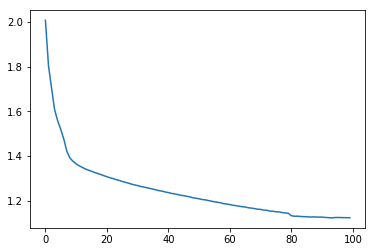

In [0]:
plt.plot(train_losses, label='Training loss')


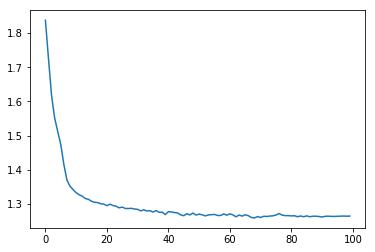

In [0]:
plt.plot(validate_losses, label='Validation loss')

# Defining CNN Model


In [0]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    
    
    # convolutional layer (sees 2x128x1 tensor)
    self.conv1 = nn.Conv2d(1, 64,(1,3) ,padding=0)
    
    # convolutional layer 
    self.conv2 = nn.Conv2d(64, 16, (2,3), padding=0)
    
    self.fc1 = nn.Linear(128*16*3, 128)
    # linear layer (500 -> 10)
    self.fc2 = nn.Linear(128, 10)
    # dropout layer (p=0.25)
    self.dropout = nn.Dropout(0.25)
    
  def forward(self, x):
    pad1 = (1, 1)
    pad2 = (1, 1, 1, 1)
    x = F.pad(x, pad1, "constant", 0)
    x = F.relu(self.conv1(x))
    x = F.pad(x, pad2, "constant", 0)
    x = F.relu(self.conv2(x))
    # reshape
    x = x.view(x.shape[0], -1)
    
    # linear 
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x
    
    

# Building CNN Model

In [0]:
model_CNN = CNN()
model_CNN.load_state_dict(torch.load('model_CNN_raw.pt'))
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
print(model_CNN)

model_CNN.to(device)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(64, 16, kernel_size=(2, 3), stride=(1, 1))
  (fc1): Linear(in_features=6144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


CNN(
  (conv1): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(64, 16, kernel_size=(2, 3), stride=(1, 1))
  (fc1): Linear(in_features=6144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

# Training CNN Model

In [0]:
n_epochs = 100
steps = 0

batch_size = 1024
num_workers = 0

validate_loss_min = 1.134916 # track change in validation loss

y_train = y_train.long()
y_validate = y_validate.long()
y_test = y_test.long()

# divide data into batches 
x_train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, num_workers=num_workers)
y_train_loader = torch.utils.data.DataLoader(y_train, batch_size=batch_size, num_workers=num_workers)

x_validate_loader = torch.utils.data.DataLoader(x_validate, batch_size=batch_size, num_workers=num_workers)
y_validate_loader = torch.utils.data.DataLoader(y_validate, batch_size=batch_size, num_workers=num_workers)

x_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size, num_workers=num_workers)
y_test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size, num_workers=num_workers)

train_losses, validate_losses = [], []
for e in range(n_epochs):
    running_loss = 0
    for samples, labels in zip(x_train_loader, y_train_loader):
      
        # Move input and label tensors to the default device
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        probabilities = model_CNN(torch.unsqueeze(samples, 1))  # add a depth size 1
        loss = criterion(probabilities, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        validate_loss = 0
        accuracy = 0
        correct = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model_CNN.eval()
            for samples, labels in zip(x_validate_loader, y_validate_loader):
              
                # Move input and label tensors to the default device
                samples, labels = samples.to(device), labels.to(device)
                
                
                probabilities = model_CNN(torch.unsqueeze(samples, 1))  # add a depth size 1
                validate_loss += criterion(probabilities, torch.max(labels, 1)[1])    
                
                top_p, top_class = probabilities.topk(1, dim=1)
                equals = top_class == torch.max(labels, 1)[1].view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                correct += torch.sum(equals.type(torch.FloatTensor))
        
        model_CNN.train()
        
        train_losses.append(running_loss/len(y_train_loader))
        validate_losses.append(validate_loss/len(y_validate_loader))
        scheduler.step(validate_losses[-1])
        
        # save the model with the minimum validation loss
        if validate_losses[-1] <= validate_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            validate_loss_min, validate_losses[-1]))
            torch.save(model_CNN.state_dict(), 'MODEL_CNN_RAW.pt')
            validate_loss_min = validate_losses[-1]
        

        print("Epoch: {}/{}.. ".format(e+1, n_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(validate_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(y_validate_loader)))
        #print("correct = ".correct)

# Confusion Matrix Plotting Function

In [0]:
true_labels = torch.max(y_test, 1)[1]
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Accuracy VS SNR

## FC  Model

snr: -20..  Test Accuracy: 0.151
snr: -18..  Test Accuracy: 0.154
snr: -16..  Test Accuracy: 0.168
snr: -14..  Test Accuracy: 0.186
snr: -12..  Test Accuracy: 0.224
snr: -10..  Test Accuracy: 0.290
snr: -8..  Test Accuracy: 0.367
snr: -6..  Test Accuracy: 0.462
snr: -4..  Test Accuracy: 0.575
snr: -2..  Test Accuracy: 0.655
snr: 0..  Test Accuracy: 0.688
snr: 2..  Test Accuracy: 0.699
snr: 4..  Test Accuracy: 0.713
snr: 6..  Test Accuracy: 0.704
snr: 8..  Test Accuracy: 0.709
snr: 10..  Test Accuracy: 0.712
snr: 12..  Test Accuracy: 0.708
snr: 14..  Test Accuracy: 0.707
snr: 16..  Test Accuracy: 0.708
snr: 18..  Test Accuracy: 0.710


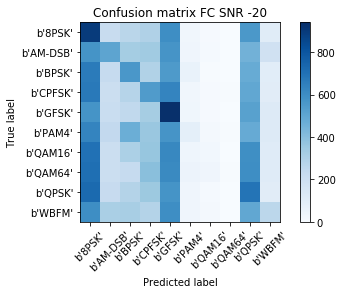

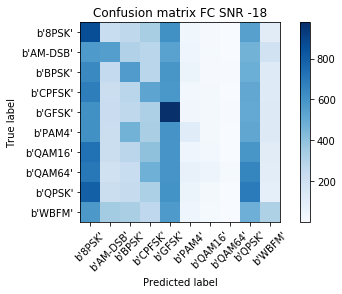

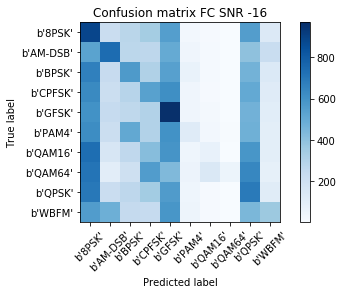

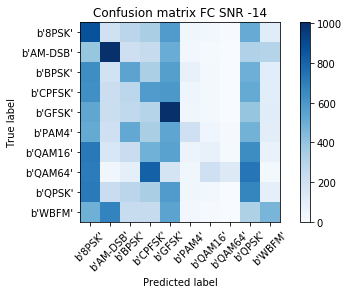

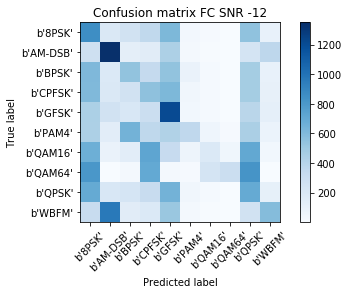

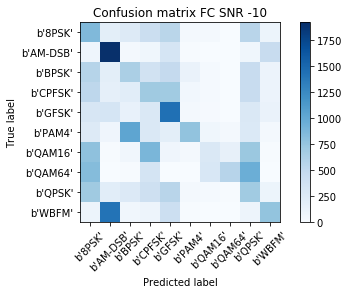

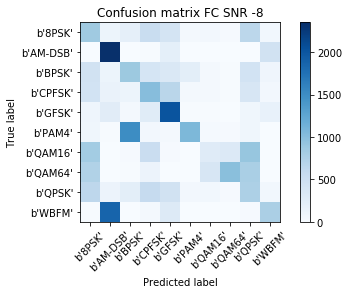

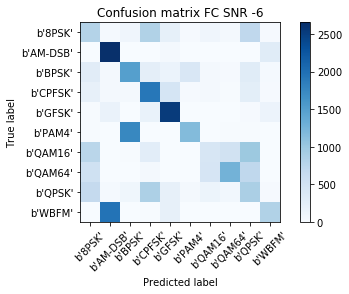

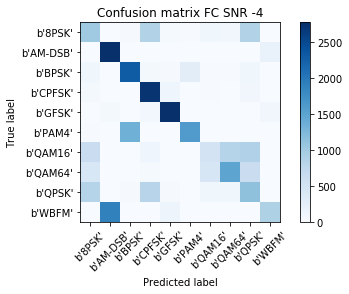

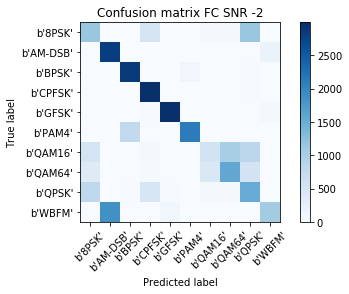

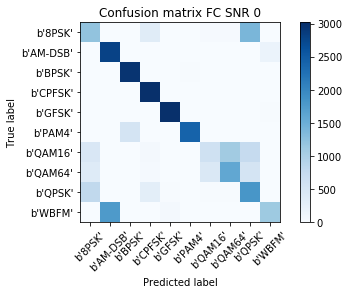

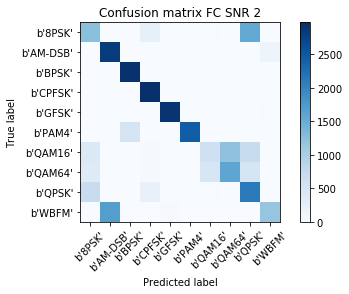

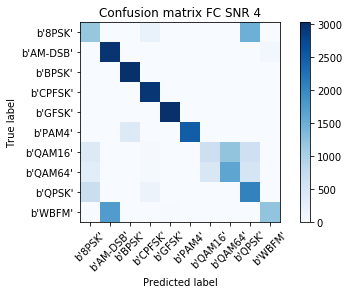

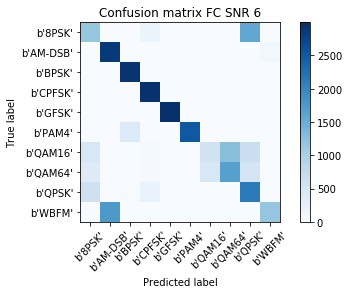

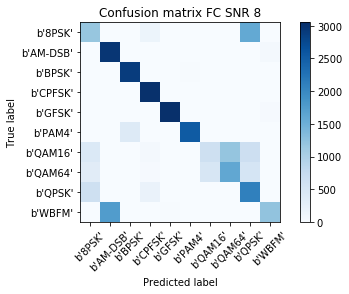

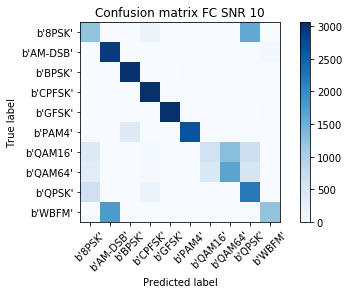

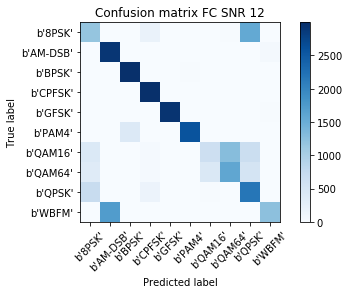

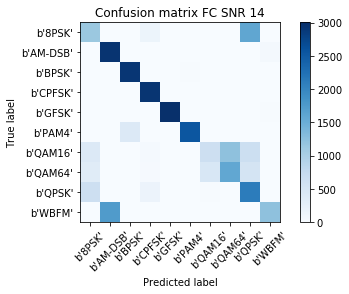

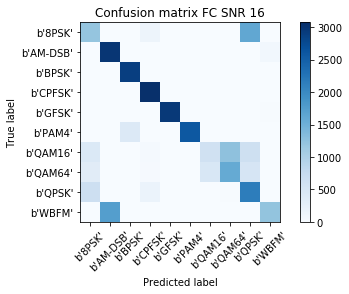

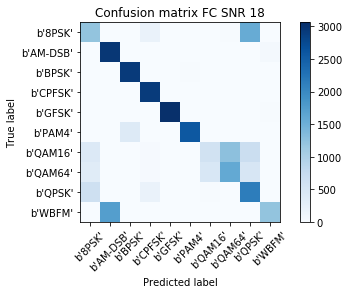

In [0]:
from sklearn.metrics import confusion_matrix

batch_size = 1024
num_workers = 0
accuracies = []
overall_predictions = []
predicted_raw = []

for snr in snrs:
    snr_y_test_loader = torch.utils.data.DataLoader(y_test[(y_test_snr == snr).nonzero()], batch_size=batch_size, num_workers=num_workers)
    snr_x_test_loader = torch.utils.data.DataLoader(x_test[(y_test_snr == snr).nonzero()], batch_size=batch_size, num_workers=num_workers)
    
    temp_per_snr = []  #**per snr
    true_label = []    #**per snr
    accuracy = 0
    correct = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for samples, labels in zip(snr_x_test_loader, snr_y_test_loader):
              
            # Move input and label tensors to the default device
            samples, labels = samples.to(device), labels.to(device)
            
            true_label.append(torch.max(labels, 1)[1])   # ****for each snr
            
    
                
            probabilities = model(torch.unsqueeze(samples, 1))  # add a depth size 1   
                
            top_p, top_class = probabilities.topk(1, dim=1)
            labels = labels.view(labels.shape[0], -1)
            predicted_raw.append(top_class)
            temp_per_snr.append(top_class)   #**per snr
            
            
            
            equals = top_class == torch.max(labels, 1)[1].view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            correct += torch.sum(equals.type(torch.FloatTensor))
            
            
        
    model.train()
    accuracies.append(accuracy/len(snr_y_test_loader))
    print("snr: {}.. ".format(snr),
              "Test Accuracy: {:.3f}".format(accuracies[-1]))
    
    #************************************
    xx = []
    for ilist in true_label:
      for i in ilist:
        xx.append(i)
      
    true_label = torch.stack(xx)
    pred_temp = []
    for sub_list in temp_per_snr:
        for item in sub_list:
            pred_temp.append(item)

    pred_temp = torch.stack(pred_temp)
    temp_conf = confusion_matrix(true_label.cpu(), pred_temp.cpu())
    plt.figure()
    plot_confusion_matrix(temp_conf, labels=mods, title='Confusion matrix FC SNR '+str(snr))
    #************************************

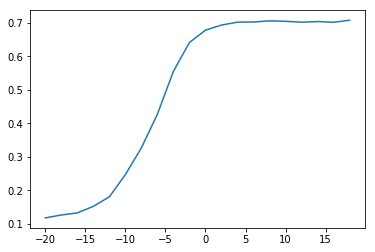

In [0]:
plt.plot(snrs, accuracies, label='accuracies')

# Computing Confusion Matrix for FC

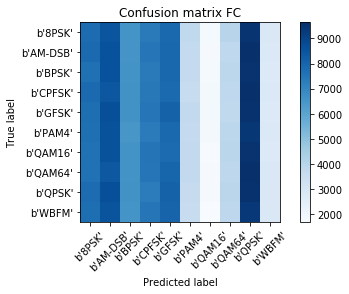

In [0]:
pred_raw = []
for sub_list in predicted_raw:
  for item in sub_list:
    pred_raw.append(item)

pred_raw = torch.stack(pred_raw)
raw_conf = confusion_matrix(true_labels.cpu(), pred_raw.cpu())
plot_confusion_matrix(raw_conf, labels=mods, title='Confusion matrix FC')

## CNN Model

snr: -20..  Test Accuracy: 0.109
snr: -18..  Test Accuracy: 0.113
snr: -16..  Test Accuracy: 0.122
snr: -14..  Test Accuracy: 0.131
snr: -12..  Test Accuracy: 0.157
snr: -10..  Test Accuracy: 0.244
snr: -8..  Test Accuracy: 0.378
snr: -6..  Test Accuracy: 0.499
snr: -4..  Test Accuracy: 0.608
snr: -2..  Test Accuracy: 0.680
snr: 0..  Test Accuracy: 0.731
snr: 2..  Test Accuracy: 0.746
snr: 4..  Test Accuracy: 0.760
snr: 6..  Test Accuracy: 0.760
snr: 8..  Test Accuracy: 0.763
snr: 10..  Test Accuracy: 0.762
snr: 12..  Test Accuracy: 0.761
snr: 14..  Test Accuracy: 0.764
snr: 16..  Test Accuracy: 0.763
snr: 18..  Test Accuracy: 0.763


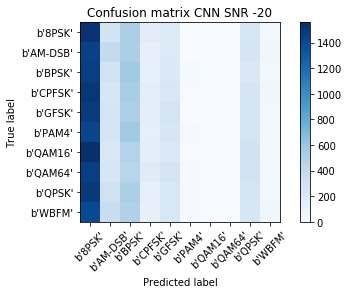

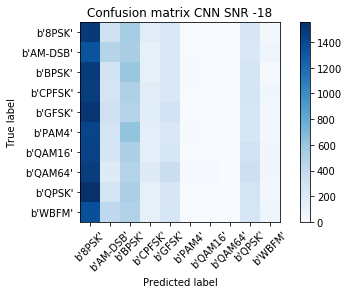

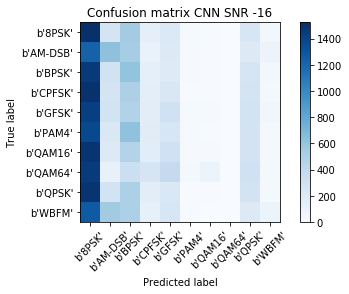

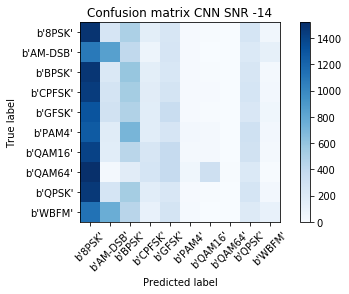

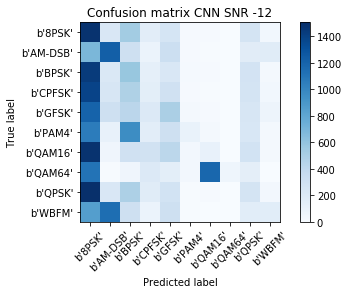

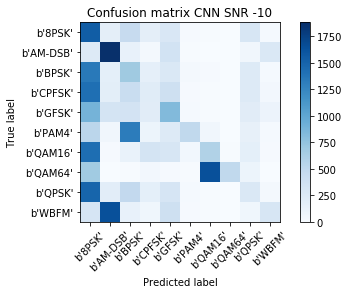

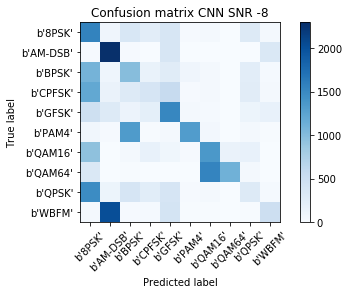

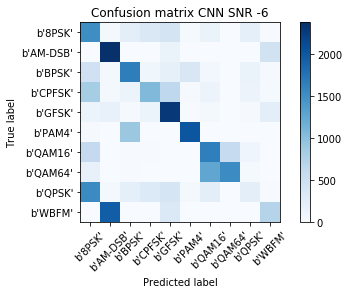

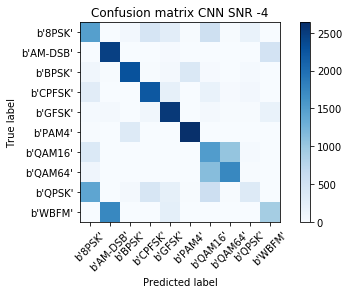

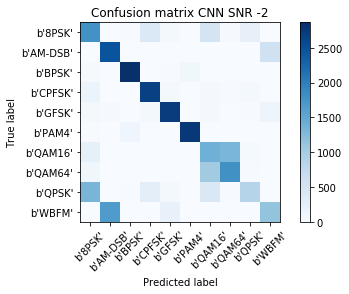

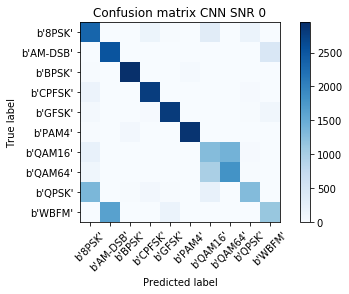

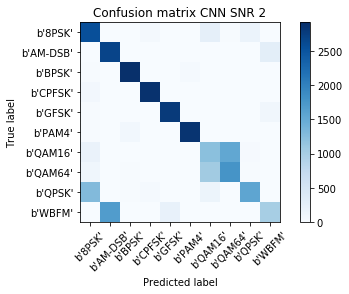

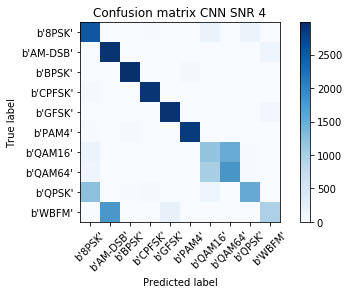

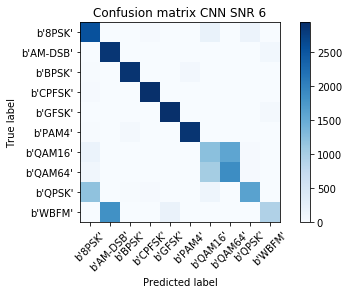

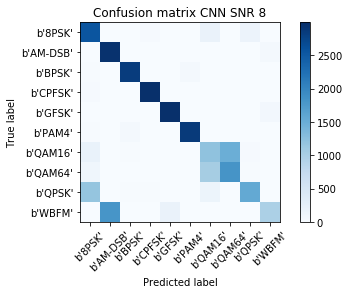

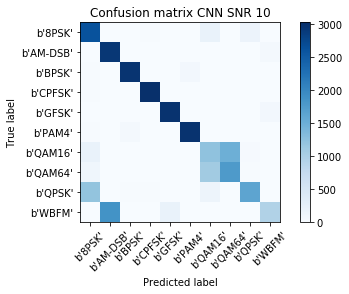

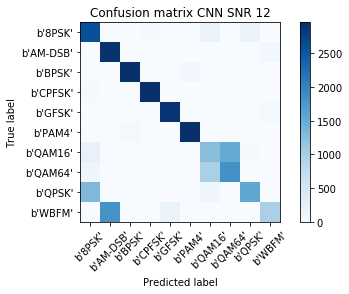

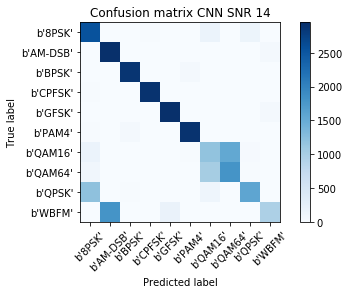

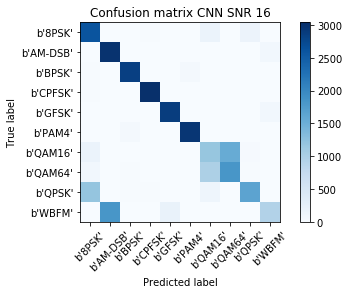

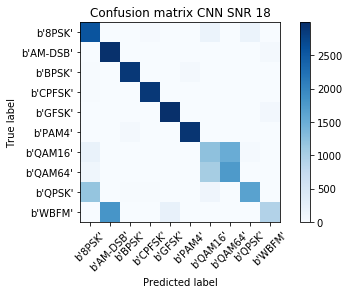

In [0]:
batch_size = 1024
num_workers = 0
accuracies2 = []
predicted_raw2 = []

for snr in snrs:
    snr_y_test_loader = torch.utils.data.DataLoader(y_test[(y_test_snr == snr).nonzero()], batch_size=batch_size, num_workers=num_workers)
    snr_x_test_loader = torch.utils.data.DataLoader(x_test[(y_test_snr == snr).nonzero()], batch_size=batch_size, num_workers=num_workers)
    
    temp_per_snr = []  #**per snr
    true_label = []    #**per snr
    accuracy = 0
    correct = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model_CNN.eval()
        for samples, labels in zip(snr_x_test_loader, snr_y_test_loader):
              
            # Move input and label tensors to the default device
            samples, labels = samples.to(device), labels.to(device)
            
            true_label.append(torch.max(labels, 1)[1])   # ****for each snr    
                
            probabilities = model_CNN(torch.unsqueeze(samples, 1))  # add a depth size 1     
            top_p, top_class = probabilities.topk(1, dim=1)
            labels = labels.view(labels.shape[0], -1)
            predicted_raw2.append(top_class)
            temp_per_snr.append(top_class)            #***per snr
            
            
            equals = top_class == torch.max(labels, 1)[1].view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            correct += torch.sum(equals.type(torch.FloatTensor))
        
    model_CNN.train()
    
    accuracies2.append(accuracy/len(snr_y_test_loader))
    print("snr: {}.. ".format(snr),
              "Test Accuracy: {:.3f}".format(accuracies2[-1]))
    
    #************************************
    xx = []
    for ilist in true_label:
      for i in ilist:
        xx.append(i)
      
    true_label = torch.stack(xx)
    pred_temp = []
    for sub_list in temp_per_snr:
        for item in sub_list:
            pred_temp.append(item)

    pred_temp = torch.stack(pred_temp)
    temp_conf = confusion_matrix(true_label.cpu(), pred_temp.cpu())
    plt.figure()
    plot_confusion_matrix(temp_conf, labels=mods, title='Confusion matrix CNN SNR '+str(snr))
    #************************************

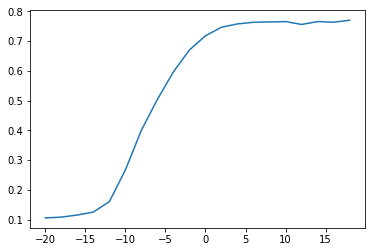

In [0]:
plt.plot(snrs, accuracies2, label='accuracies')

# Computing Confusion Matrix for CNN

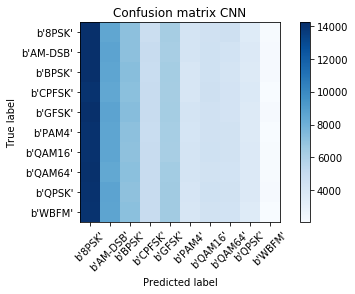

In [0]:
pred_raw = []
for sub_list in predicted_raw2:
  for item in sub_list:
    pred_raw.append(item)

pred_raw = torch.stack(pred_raw)
raw_conf = confusion_matrix(true_labels.cpu(), pred_raw.cpu())
plot_confusion_matrix(raw_conf, labels=mods, title='Confusion matrix CNN')

In [0]:
print(len(top_class))

230


In [0]:
print(pred_raw.shape)

torch.Size([600000, 1])


In [0]:
print(len(true_label))

30


In [0]:
print(true_label.shape)

torch.Size([29930])
